In [67]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from datetime import datetime

In [71]:
with open("data/series_v2_1.json", "r") as f:
    data = json.load(f)
    
with open("data/corpus_v2.json", "r") as f:
    corpus = json.load(f)
    
def convert_column_float64(df, column):
    df.loc[:,column] = df.loc[:,column].astype(np.float64)
    return df

def add_submission_column(df, _id):
    df["submission"] = _id
    return df

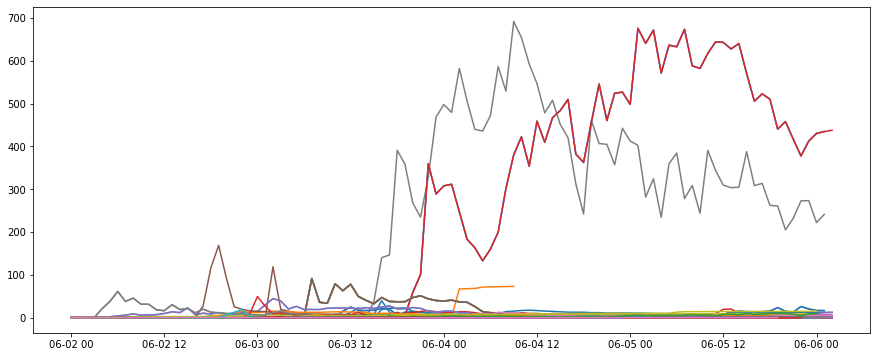

In [72]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot()
dfs = []

for _id in data:
    dex_trades = data[_id].get("series", {}).get("data", {}).get("ethereum",{}).get("dexTrades", [])
    
   
    if len(dex_trades) == 0:
        continue
        
        
    df = pd.json_normalize(dex_trades).pipe(convert_column_float64, column="close_price")\
        .pipe(convert_column_float64, column="minimum_price")\
        .pipe(convert_column_float64, column="maximum_price")\
        .pipe(convert_column_float64, column="quotePrice")\
        .pipe(convert_column_float64, column="tradeAmount")\
        .pipe(convert_column_float64, column="trades")\
        .pipe(convert_column_float64, column="open_price")\
        .pipe(add_submission_column, _id=_id)

    dfs.append(df)
        
#     print(dex_trades[0]["baseCurrency"]["symbol"])
    y = [float(item["close_price"]) for item in dex_trades]
    x = [datetime.fromisoformat(item["timeInterval"]["minute"][:-1]) for item in dex_trades]
    
    series = pd.Series(data=y, index=x)
    cumprod = series.pct_change().fillna(0).add(1).cumprod().sub(1)
    ax.plot(cumprod, label=_id)

plt.show()

In [78]:
from tensorflow import keras

In [70]:
# https://tfhub.dev/google/nnlm-en-dim50/2
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")

In [74]:
embeddings = {}
for payload in tqdm(corpus):
    text = payload["text"]
    title = payload["title"]
    comments = " ".join(payload["comments"])
    a,b,c = embed([text, title, comments])
    
    _id = payload["id"]
    embeddings[_id] = {"text":a, "title":b, "comments": c }

100%|██████████| 713/713 [00:00<00:00, 1465.68it/s]


In [114]:
x_train = []
y_train = []
for k, v in embeddings.items():
    x = np.concatenate(list(v.values())).reshape([-1, 50])
    x_train.append(x)
    
x_train = np.array(x_train)   
y_train = np.random.random(len(x_train))

array([[ 0.7879302 ,  0.09918634, -0.14280485, ..., -0.29584178,
         0.2682127 ,  1.0750861 ],
       [ 0.7886573 ,  0.27049243,  0.13592605, ..., -0.2089575 ,
         0.16178355,  0.82743055],
       [ 0.9889877 ,  0.19767337,  0.19427343, ..., -0.5204852 ,
        -0.02799946,  0.5436704 ],
       ...,
       [ 1.0506346 ,  0.29873636,  0.0072452 , ..., -0.24503393,
        -0.12671931,  0.8169725 ],
       [ 0.63199323,  0.17335673,  0.1375003 , ..., -0.03584766,
         0.44915104,  1.061978  ],
       [ 1.1239544 , -0.01892194, -0.4979872 , ..., -0.28588155,
         0.21391453,  0.95108926]], dtype=float32)

In [107]:

text_inputs = keras.Input(shape=(50))
title_inputs = keras.Input(shape=(50))
comments_inputs = keras.Input(shape=(50))
inputs = keras.layers.concatenate([text_inputs, title_inputs, comments_inputs], axis=1)
x = keras.layers.Dense(150)(inputs)
x = keras.layers.Dense(100)(x)
x = keras.layers.Dense(50)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs=[text_inputs,title_inputs,comments_inputs], outputs=outputs, name="mnist_model")

In [120]:
model.compile(
    loss="mse",
    optimizer="nadam"
)

history = model.fit([x_train[:, 0],x_train[:, 1], x_train[:, 2]], y_train, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
18/18 [==============================] - 1s 6ms/step - loss: 0.0936 - val_loss: 0.1160
Epoch 2/20
18/18 [==============================] - 0s 2ms/step - loss: 0.0843 - val_loss: 0.1111
Epoch 3/20
18/18 [==============================] - 0s 2ms/step - loss: 0.0862 - val_loss: 0.1110
Epoch 4/20
18/18 [==============================] - 0s 2ms/step - loss: 0.0850 - val_loss: 0.1158
Epoch 5/20
18/18 [==============================] - 0s 2ms/step - loss: 0.0801 - val_loss: 0.1052
Epoch 6/20
18/18 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.1130
Epoch 7/20
18/18 [==============================] - 0s 2ms/step - loss: 0.0812 - val_loss: 0.1040
Epoch 8/20
18/18 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.1021
Epoch 9/20
18/18 [==============================] - 0s 2ms/step - loss: 0.0788 - val_loss: 0.1048
Epoch 10/20
18/18 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.1176
Epoch 11/20
18/18 [